In [81]:
from datetime import time
from matplotlib import markers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from glob import glob
from seaborn import palettes
from seaborn.categorical import swarmplot
from tqdm import tqdm
import json
from scipy.signal import detrend
from scipy.ndimage import gaussian_filter1d
import os
import re
import math
import matplotlib.ticker as tck
import glob
import argparse

In [106]:
paths = glob.glob(os.path.join("D:/Turku/lunagel_50s/remodelling", "**","summary_ID_level.csv"),recursive=True)
print(paths)

['D:/Turku/lunagel_50s/remodelling\\24_120\\1\\241111\\241111_10um_3layer_50s_MDAMB231\\results\\summary_ID_level.csv', 'D:/Turku/lunagel_50s/remodelling\\24_120\\1\\241111\\241111_10um_3layer_50s_control\\results\\summary_ID_level.csv', 'D:/Turku/lunagel_50s/remodelling\\24_120\\0\\241107\\241107_10um_3layer_50s_control\\results\\summary_ID_level.csv', 'D:/Turku/lunagel_50s/remodelling\\24_120\\0\\241107\\241107_10um_3layer_50s_MDAMB231\\results\\summary_ID_level.csv', 'D:/Turku/lunagel_50s/remodelling\\48_144\\0\\241108\\241108_10um_3layer_50s_control\\results\\summary_ID_level.csv', 'D:/Turku/lunagel_50s/remodelling\\48_144\\0\\241108\\241108_10um_3layer_50s_MDAMB231\\results\\summary_ID_level.csv', 'D:/Turku/lunagel_50s/remodelling\\48_144\\1\\241112\\241112_10um_3layer_50s_control\\results\\summary_ID_level.csv', 'D:/Turku/lunagel_50s/remodelling\\48_144\\1\\241112\\241112_10um_3layer_50s_MDAMB231\\results\\summary_ID_level.csv']


In [116]:
df_list = []

for i in (paths):
    k=0
    data = pd.read_csv(i)
    parts = i.split('\\')
    data['set'] = parts[1]
    data['set_id'] = parts[2]
    data['date'] = parts[3] 
    data['sample'] = parts[4].split('_')[4]
    df_list.append(data)
    print(f"{parts[1]},{parts[2]},{ parts[3] },{parts[4].split('_')[4]}")
    

df = pd.concat(df_list, ignore_index=True)


24_120,1,241111,MDAMB231
24_120,1,241111,control
24_120,0,241107,control
24_120,0,241107,MDAMB231
48_144,0,241108,control
48_144,0,241108,MDAMB231
48_144,1,241112,control
48_144,1,241112,MDAMB231


In [125]:
saving_path = 'C:/Users/srboval1/OneDrive - Aalto University/Collab/Ivaska_collab/data'
df.to_csv(saving_path+'/gradients.csv')  

download = pd.read_csv(saving_path +'/gradients.csv', index_col=None)
print(download.columns)


Index(['Unnamed: 0', 'day', 'sample', 'holder', 'location', 'track_id',
       'reference_id', 'distance(um)', 'Cov_Sum', 'a_(um)', 'phi_(rad)', 'c',
       'd', 'G_abs', 'radius_(m)', 'rmse', 'inv.rmse', 'shift_(s)', 'a_error',
       'phi_error', 'c_error', 'd_error', 'x', 'y', 'repeat', 'phi_(deg)',
       'tan_phi', 'set', 'set_id', 'date', 'gradient', 'x_con'],
      dtype='object')


1
0
1
0


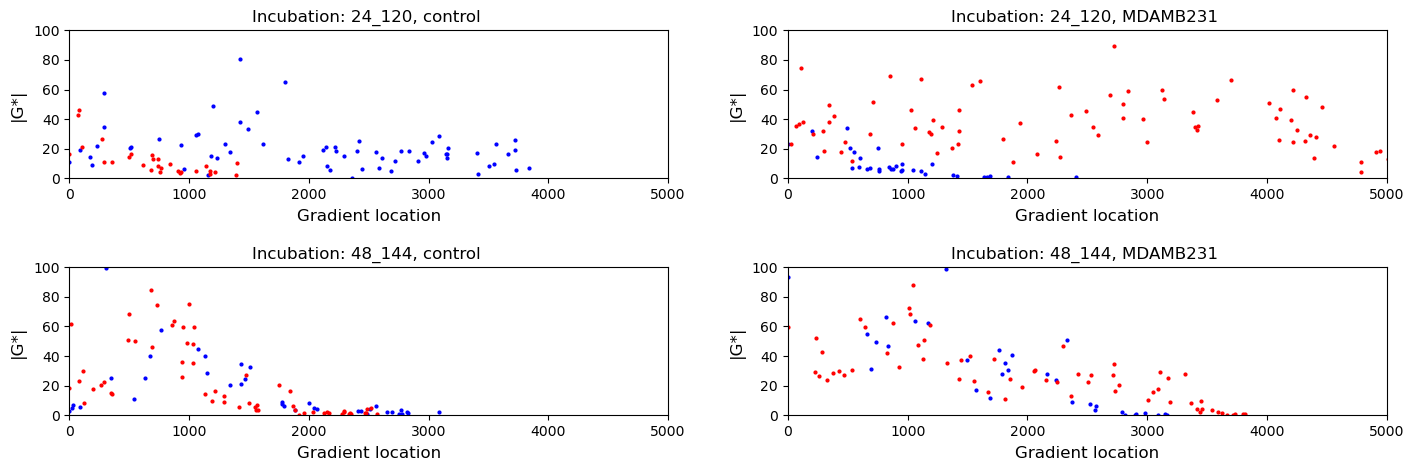

In [136]:
fig, axs = plt.subplots(2, (len(df['set'].unique())), figsize=(17, 5))
plt.subplots_adjust(wspace=0.2, hspace=0.6)
fig.suptitle("", fontsize=18, y=1)

colors = ["red","blue"]
for i,j in enumerate(df['set'].unique()):
    dff = df[df['set']==j]
    row = i
    for n in(df['set_id'].unique()):
        print(n)
        dfff = dff[dff['set_id']==n]
        color = colors[int(n)]
        for m,n in enumerate(dfff['sample'].unique()):
            dffff = dfff[dfff['sample']==n]
            dffff = dffff.copy()
            if (n == "MDAMB231") & (dfff['date'].unique() == "241107"):
                dffff['f'] = dffff['gradient']
            else:
                dffff['f'] = dffff['gradient'].max() - dffff['gradient']
            col = m
            ax = axs[row,col]
            ax.scatter(dffff['f'],dffff['G_abs'],s=4, c=color) #measured from soft to stiff
            ax.set_xlabel("Gradient location", fontsize= 12,labelpad=5)
            ax.set_ylabel("|G*|", fontsize= 12, labelpad=5)
            ax.set_title(f"Incubation: {j}, {n} ", fontsize = 12)
            ax.set_ylim (0,100) 
            ax.set_xlim (0,5000)  

1
1
1
1


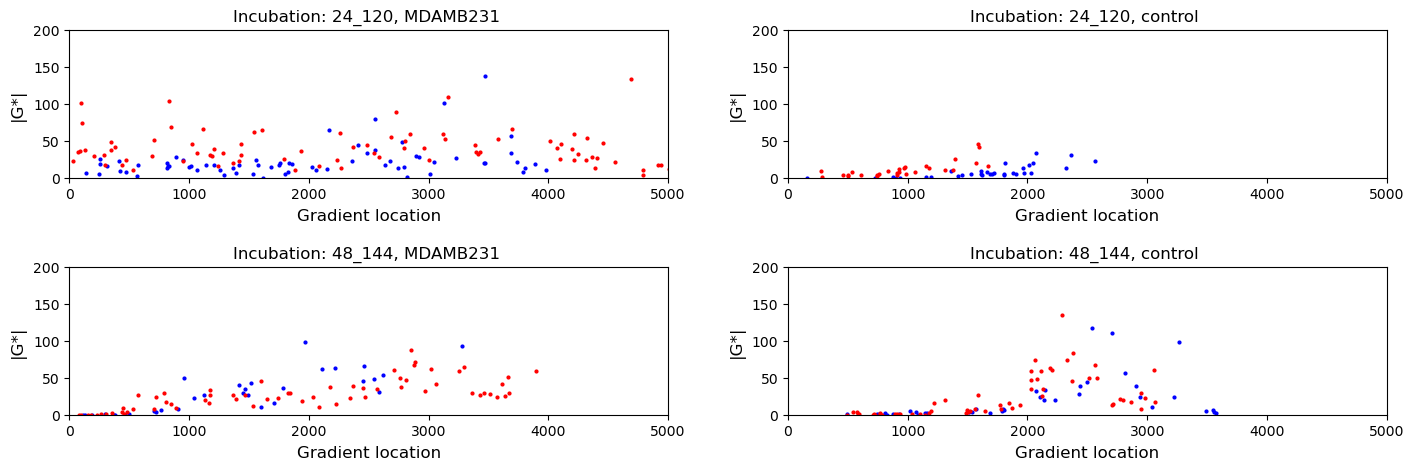

In [ ]:
fig, axs = plt.subplots(2, (len(df['set'].unique())), figsize=(17, 5))
plt.subplots_adjust(wspace=0.2, hspace=0.6)
fig.suptitle("", fontsize=18, y=1)

colors = ["red","blue"]
for i,j in enumerate(df['set'].unique()):
    dff = df[df['set']==j]
    row = i
    for n in(df['set_id'].unique()):
        dfff = dff[dff['set_id']==n]
        color = colors[int(n)]
        for m,n in enumerate(df['sample'].unique()):
            dffff = dfff[dfff['sample']==n]
            col = m
            ax = axs[row,col]
            ax.scatter(dffff['gradient'],dffff['G_abs'],s=4, c=color) #measured from soft to stiff
            ax.set_xlabel("Gradient location", fontsize= 12,labelpad=5)
            ax.set_ylabel("|G*|", fontsize= 12, labelpad=5)
            ax.set_title(f"Incubation: {j}, {n} ", fontsize = 12)
            ax.set_ylim (0,200) 
            ax.set_xlim (0,5000)  

Text(0.5, 1.0, 'Cell sample 24h')

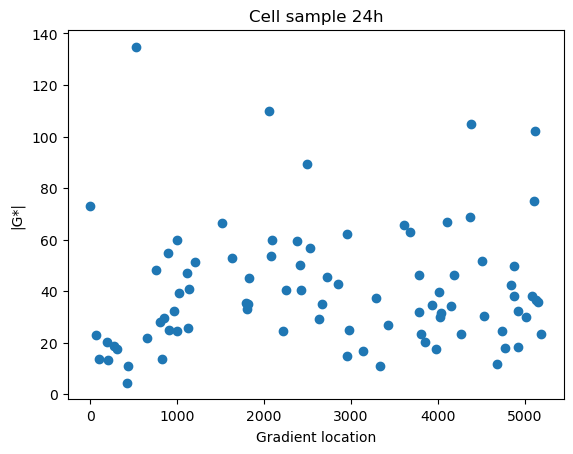

In [ ]:
plt.scatter(df['x_con'],df['G_abs'])
plt.xlabel("Gradient location", fontsize= 10,labelpad=5)
plt.ylabel("|G*|", fontsize= 10, labelpad=5)
plt.title('Cell sample 24h')


Text(0.5, 1.0, 'Control sample 24h')

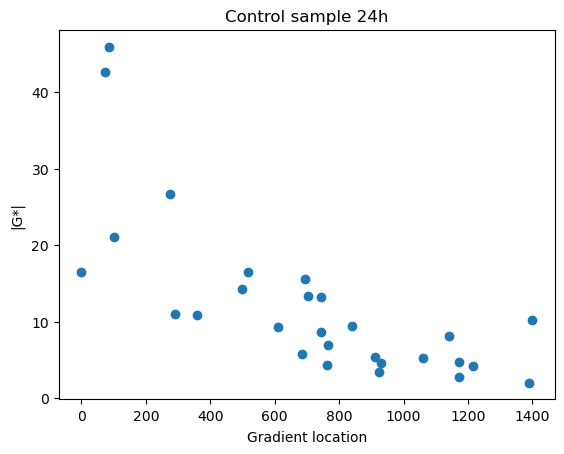

In [9]:
max = control['gradient'].max()
control['x_con'] = max -control['gradient']
control.to_csv('C:/Users/srboval1/OneDrive - Aalto University/Collab/Ivaska_collab/data/241107_24h_control', index=False)

plt.scatter(control['x_con'],control['G_abs'])
plt.xlabel("Gradient location", fontsize= 10,labelpad=5)
plt.ylabel("|G*|", fontsize= 10, labelpad=5)
plt.title('Control sample 24h')